<a href="https://colab.research.google.com/github/GabsAki/sar_sentence_classification/blob/main/Gabriel_Okazaki_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/GabsAki/sar_sentence_classification/main/sar_sentences.csv")
df.head()

,Sentence,Category
0,The project deadline was approaching rapidly.,Situation
1,I conducted a thorough market analysis to iden...,Action
2,We successfully exceeded our sales target by 25%.,Result
3,The weather was unpredictable.,Situation
4,I decided to implement a new training program.,Action


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1187 non-null   object
 1   Category  1187 non-null   object
dtypes: object(2)
memory usage: 18.7+ KB


The dataset was generated by ChatGPT and hand labeled data. Each row contains a sentece and a category, which can be Situation, Action or Result

In [ ]:
# Checking the balance of categories in the dataset
df['Category'].value_counts()

Category
Situation    412
Result       397
Action       378
Name: count, dtype: int64

# Pre-processing

In [ ]:
from sklearn.model_selection import train_test_split

X = df["Sentence"]

# Map the categories to numerical labels
LABEL_MAPPING = {'Situation':0, 'Action':1, 'Result': 2}
df['label'] = df['Category'].map(LABEL_MAPPING)

y = df["label"]

# Splitting the dataset in a statified manner so that both train and test sets are balanced in terms of categories
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reseting the index so that we can use X_train[0], for example
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print(f"Train labels distribution: {y_train.value_counts()}")
print(f"Test labels distribution: {y_test.value_counts()}")

Train labels distribution: label
0    329
2    318
1    302
Name: count, dtype: int64
Test labels distribution: label
0    83
2    79
1    76
Name: count, dtype: int64


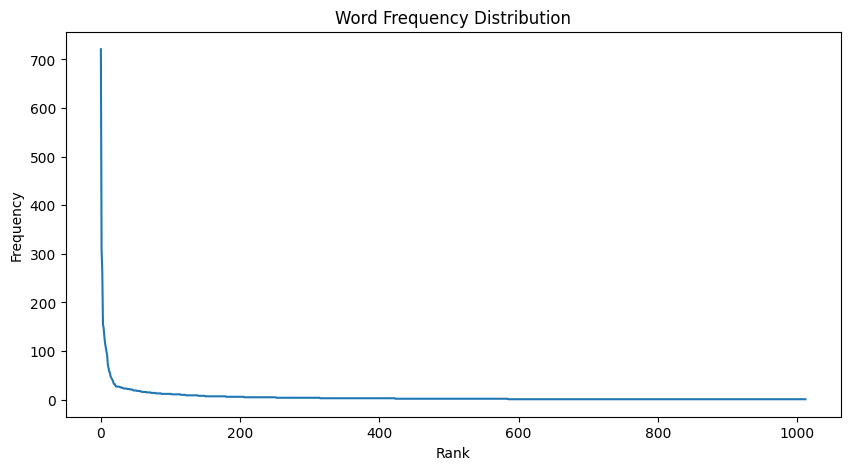

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
import matplotlib.pyplot as plt

# Crate a preview tokenizer to check word frequency
tokenizer_preview = Tokenizer()
tokenizer_preview.fit_on_texts(X_train)

word_counts = tokenizer_preview.word_counts
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*sorted_counts)

# Plot word frequency
plt.figure(figsize=(10, 5))
plt.plot(range(len(counts)), counts)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution')
plt.show()

We can see that frequency drops off significantly after 200 words

In [ ]:
# Check top 10 words. The dataset has a lot of business vocabulary because of how it was generated.
sorted_counts[:10]

[('the', 721),
 ('i', 308),
 ('was', 265),
 ('to', 155),
 ('a', 147),
 ('project', 130),
 ('team', 116),
 ('product', 108),
 ('were', 99),
 ('customer', 91)]

In [ ]:
# Defining pre-processing parameters
oov_tok = '<OOV>'  # out of vocabulary token
vocab_size = 200  # The maximum number of unique tokens

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

1014

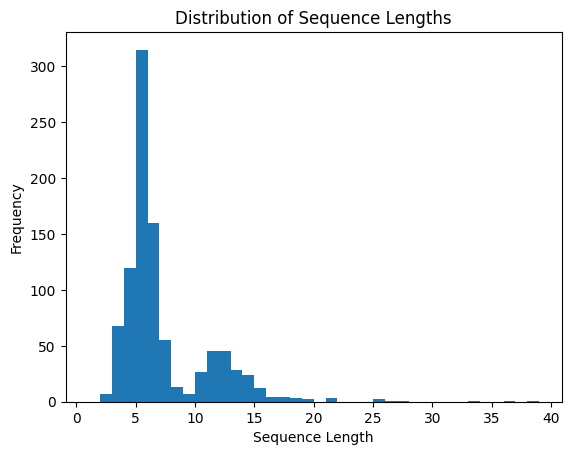

Mean length: 6.8145416227608
Median length: 5.0
90th percentile length: 12.0
95th percentile length: 14.0
Chosen maxlen: 14


In [ ]:
import numpy as np

training_sequences = tokenizer.texts_to_sequences(X_train)

# Calculate sequence lengths
sequence_lengths = [len(seq) for seq in training_sequences]

# Plot distribution of sequence lengths
plt.hist(sequence_lengths, bins=range(1, max(sequence_lengths) + 2))
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Calculate statistics
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
percentile_90 = np.percentile(sequence_lengths, 90)
percentile_95 = np.percentile(sequence_lengths, 95)

print(f"Mean length: {mean_length}")
print(f"Median length: {median_length}")
print(f"90th percentile length: {percentile_90}")
print(f"95th percentile length: {percentile_95}")

# Choose maxlen based on the 90th or 95th percentile
maxlen = int(percentile_95)
print(f"Chosen maxlen: {maxlen}")

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

training_sequences = tokenizer.texts_to_sequences(X_train)

max_len = 14
# Post padding and truncation are recommended for the model we will use (Bi-directional LSTM)
trunc_type = 'post'
padding_type = 'post'

training_padded = pad_sequences(
    training_sequences,
    maxlen = max_len,
    padding = padding_type,
    truncating = trunc_type
)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(
    testing_sequences,
    maxlen = max_len,
    padding = padding_type,
    truncating = trunc_type
)

# Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Since our sequences are not long and our task is simple (classification), we chose smaller numbers for n_lstm and embedding_dim
n_lstm = 32
embedding_dim = 16

# Dropout layer and kernel_regularizer L2 were added to prevent overfitting
l2_penalty = 0.02
drop_lstm = 0.2

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model.add(Bidirectional(LSTM(n_lstm, return_sequences = False, kernel_regularizer=l2(l2_penalty))))
model.add(Dropout(drop_lstm))
model.add(BatchNormalization())
model.add(Dense(3, activation = 'softmax', kernel_regularizer=l2(l2_penalty)))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 14, 16)            3200      
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                12544     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 16195 (63.26 KB)
Trainable params: 16067

# Training

In [ ]:
model.compile(
    loss = 'sparse_categorical_crossentropy',  # Used Sparse Categorical Cross Entropy since we have 3 classes represented as integers
    optimizer = 'adam',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 30

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  # Early stopping inplemented to prevent overfitting

history = model.fit(
    training_padded,
    y_train,
    epochs=num_epochs,
    validation_data=(testing_padded, y_test),
    callbacks =[early_stop],Read
    verbose=2
)

Epoch 1/30
30/30 - 7s - loss: 1.9738 - accuracy: 0.6122 - val_loss: 1.9542 - val_accuracy: 0.4538 - 7s/epoch - 238ms/step
Epoch 2/30
30/30 - 0s - loss: 1.3256 - accuracy: 0.7924 - val_loss: 1.6688 - val_accuracy: 0.5126 - 445ms/epoch - 15ms/step
Epoch 3/30
30/30 - 0s - loss: 0.9199 - accuracy: 0.8830 - val_loss: 1.4655 - val_accuracy: 0.4034 - 467ms/epoch - 16ms/step
Epoch 4/30
30/30 - 0s - loss: 0.6579 - accuracy: 0.9189 - val_loss: 1.3093 - val_accuracy: 0.6134 - 461ms/epoch - 15ms/step
Epoch 5/30
30/30 - 0s - loss: 0.5254 - accuracy: 0.9210 - val_loss: 1.1716 - val_accuracy: 0.8782 - 481ms/epoch - 16ms/step
Epoch 6/30
30/30 - 0s - loss: 0.4332 - accuracy: 0.9315 - val_loss: 1.0543 - val_accuracy: 0.8782 - 480ms/epoch - 16ms/step
Epoch 7/30
30/30 - 0s - loss: 0.3745 - accuracy: 0.9336 - val_loss: 0.9715 - val_accuracy: 0.8403 - 463ms/epoch - 15ms/step
Epoch 8/30
30/30 - 0s - loss: 0.3348 - accuracy: 0.9305 - val_loss: 0.8525 - val_accuracy: 0.8025 - 470ms/epoch - 16ms/step
Epoch 9/30

# Hyper parameter tuning

These were the experiments done during hyper parameter tuning:
- **n_lstm (number of neurons in the LSTM layer)**: Started with 50, but reduced to 32 considering the simplicity of the task and to avoid overfitting
- **l2_penalty (Value of penalty applied in L2 regularizatoin)**: Started with 0.01 but incresed to 0.02 to avoid overfitting
- **drop_lstm (% of drop in Dropout layer after LSTM layer)**: Started with 0.15 but increased to 0.2 to avoid overfitting
- **num_epochs**: Set at 30 but early stopping always stopped training before 25 epochs.
- **early_stopping_patience**: Started at 3 but reduced to 2 to avoid overfitting.

# Saving the model

In [ ]:
from tensorflow.keras.models import save_model

# Saving with Keras, default `.pb` format
save_model(model, './sar_classifier/keras_pb/')

In [ ]:
import shutil

# Create a zip file with model that can be dowloaded from Google Colab
shutil.make_archive("sar_classifier", 'zip', "sar_classifier")

'/content/sar_classifier.zip'

# Predicting Sentences

In [ ]:
reverse_mapping = {v: k for k, v in LABEL_MAPPING.items()}

# Function to get the key from the integer value
def get_key_from_value(value):
    return reverse_mapping[value]

In [ ]:
def predict_category(predict_msg, verbose=False):
    new_seq = tokenizer.texts_to_sequences(predict_msg)

    padded = pad_sequences(
        new_seq,
        maxlen = max_len,
        padding = padding_type,
        truncating = trunc_type
    )

    prediction = model.predict(padded)
    predicted_category = get_key_from_value(int(np.argmax(prediction, axis=-1)[0]))


    if verbose:
        print(f"Prediction array: {prediction}")
        print(f"Predicted class: {predicted_category}")

    return predicted_category

In [ ]:
# Example sentences that should be predicted as Situation
predict_category(["Customers started being affected by a bug due to our most recent deploy"], verbose=True)
predict_category(["One of my co-workers was set in his ways ansd was losing his patience in the discussion with the other technical team"], verbose=True)

1/1 [==============================] - 1s 805ms/step
Prediction array: [[0.941909   0.04496868 0.01312219]]
Predicted class: Situation
1/1 [==============================] - 0s 24ms/step
Prediction array: [[0.97127837 0.01434894 0.01437267]]
Predicted class: Situation


'Situation'

In [ ]:
# Example sentences that should be predicted as Action
predict_category(["I promptly opened an incident and alerted all parties involved"], verbose=True)
predict_category(["I reminded everyone that we were in the same team and that we each can contribute with different perspectives"], verbose=True)

1/1 [==============================] - 0s 22ms/step
Prediction array: [[5.1926469e-05 9.9965549e-01 2.9252836e-04]]
Predicted class: Action
1/1 [==============================] - 0s 24ms/step
Prediction array: [[8.5002906e-04 9.9828488e-01 8.6506392e-04]]
Predicted class: Action


'Action'

In [ ]:
# Example sentences that should be predicted as Result
predict_category(["My team's initiative saved the company 1 million dollars per year"], verbose=True)
predict_category(["In the end, the project saved the company 1 million dollers per year"], verbose=True)

1/1 [==============================] - 0s 23ms/step
Prediction array: [[0.41846022 0.08887616 0.49266368]]
Predicted class: Result
1/1 [==============================] - 0s 21ms/step
Prediction array: [[0.12978202 0.01093934 0.8592786 ]]
Predicted class: Result


'Result'

# Analysing interview answers

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
all_categories = ["Situation", "Action", "Result"]

def find_missing_elements(received_list):
    master_set = set(all_categories)
    received_set = set(received_list)
    missing_elements = list(master_set - received_set)
    return missing_elements

In [ ]:
from nltk.tokenize import sent_tokenize


def analyse_answer(answer):
    sentences = sent_tokenize(answer)
    sentence_categories = []

    for sentence in sentences:
        sentence_categories.append(predict_category([sentence], verbose=False))

    for sentence, category in zip(sentences, sentence_categories):
        print(f"Sentence: {sentence}; Category: {category}")

    missing_categories = find_missing_elements(sentence_categories)

    if not missing_categories:
        print("All categories present in answer. The answer follows the SAR format")
    else:
        print(f"The following category/categories are missing from the answer: {missing_categories}")

In [ ]:
# Should be judged as a complete answer
answer1 = "There was an issue with supply chain. I analyzed data and provided my boss two options and they decided to dig into one area, ordering. Based on my findings and the work we did, the turnaround time from ordering all the way to shipping reduced from 2 weeks to 5 days."

analyse_answer(answer1)

1/1 [==============================] - 0s 21ms/step
Sentence: There was an issue with supply chain.; Category: Situation
Sentence: I analyzed data and provided my boss two options and they decided to dig into one area, ordering.; Category: Action
Sentence: Based on my findings and the work we did, the turnaround time from ordering all the way to shipping reduced from 2 weeks to 5 days.; Category: Result
All categories present in answer. The answer follows the SAR format


In [ ]:
# Lacking a Result
answer2 = "Revenue was down in the quarter. I analyzed revenue streams for the previous six months to identify bottlenecks or gaps in our sales cycle."

analyse_answer(answer2)

1/1 [==============================] - 0s 138ms/step
Sentence: Revenue was down in the quarter.; Category: Result
Sentence: I analyzed revenue streams for the previous six months to identify bottlenecks or gaps in our sales cycle.; Category: Action
The following category/categories are missing from the answer: ['Situation']


In [ ]:
# Lacking a Situation
answer3 = "I was gossiping with my classmates. We came up with a solution to do forecasting."

analyse_answer(answer3)

1/1 [==============================] - 0s 22ms/step
Sentence: I was gossiping with my classmates.; Category: Action
Sentence: We came up with a solution to do forecasting.; Category: Result
The following category/categories are missing from the answer: ['Situation']


# Conclusion

**Resource utilization**: The model is very lightweight, and the dataset is not huge. Only CPU was enough

**Nexts steps**:
- **Improve dataset:** Get a larger dataset with a bigger variety of sentences, encapsulating different ways of writing
- **Make model more complex:** With a richer dataset, it is possible to add more layers and more neurons to each layer to capture more patterns without overfitting.
- **Capture the order of the sentences:** A sentence might be a Situation or Result if it is placed in the beggining or the and of a complete answer. Currently, the model can only evaluate each sentence separately, but analyzing the order of the sentences would improve the model a lot.

**Lessons learned**:
- A dataset that is too small makes every sentence very important, especially if you are training an LSTM from scratch
- LLMs are very efficient tools for helping in generating datasets. However, it is necessary to be wary that the sentences produced might be too similar or might all be written in a similar "manner of speech". This might heavily affect your model.
- Semantics like the difference between a Situation in a Result can be quite subjective, even for humans. However, this Bi-Directional LSTM did a good job of capturing these nuances given the circumstances.